http://www.studyai.cn/modules/calibration.html

https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

https://blog.csdn.net/fzcoolbaby/article/details/99174601

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

## 读取数据

1) csv 数据读取格式：

pd.read_csv("xxx.csv")

pd.read_csv("xxx.csv", encoding='gb18030')

pd.read_csv("xxx.csv", encoding='utf-8')

如有需要，添加参数 engine='python'

2) xlsx读取格式：

pd.read_excel("xxx.xlsx")

In [2]:
df = pd.read_excel('电信客户流失.xlsx')
df.head()

,地区,用时,年龄,婚姻,住址,收入,学历,工龄,退休,性别,...,三方通话,手机支付,长途日志,免费服务日志,设备日志,电话卡日志,无线日志,收入日志,类型,流失
0,2,13,44,1,9,64,4,5,0,0,...,0,0,1.308333,NaN,NaN,2.014903,NaN,4.158883,1,1
1,3,11,33,1,7,136,5,5,0,0,...,1,0,1.481605,3.032546,NaN,2.724580,3.575151,4.912655,4,1
2,3,68,52,1,24,116,1,29,0,1,...,1,0,2.898671,2.890372,NaN,3.409496,NaN,4.753590,3,0
3,2,33,33,0,12,33,2,0,0,1,...,0,0,2.246015,NaN,NaN,NaN,NaN,3.496508,1,1
4,2,23,30,1,9,30,1,2,0,0,...,1,0,1.840550,NaN,NaN,NaN,NaN,3.401197,3,0


In [3]:
X = df[['地区', '用时', '年龄', '婚姻', '住址', '收入', '学历', '工龄', '退休', '性别']]
y = df[['流失']]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

### 1. 基本流程
1）训练一个分类器

In [5]:
from sklearn.naive_bayes import GaussianNB

# 以朴素贝叶斯分类器为例子
clf = GaussianNB()
clf.fit(X_train, y_train)

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GaussianNB()

2) 返回预测概率，计算brier分数

In [6]:
y_proba = clf.predict_proba(X_test)[:, 1]
clf_score = brier_score_loss(y_test, y_proba)
clf_score

0.3137318805537516

3) 进行概率校准

核心函数：sklearn.calibration.CalibratedClassifierCV

主要参数：

    base_estimator ：初始分类函数

    method ：校准采用的方法。取值‘sigmoid’ 或者 ‘isotonic’

    cv ：交叉验证的折叠次数。    

In [7]:
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
clf_isotonic.fit(X_train, y_train)

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


CalibratedClassifierCV(base_estimator=GaussianNB(), cv=2, method='isotonic')

4) 计算校准后的brier分数

In [8]:
y_proba_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
clf_score_isotonic = brier_score_loss(y_test, y_proba)
clf_score_isotonic

0.3137318805537516

5) 绘制校准前后的图

y_test: 测试集的真是标签

y_proba：原始模型的预测概率

y_proba_isotonic：校准模型的预测概率

n_bins：画图时的分组数

In [9]:
def plot_calibration_curve(y_test, y_proba, y_proba_isotonic, n_bins=10):
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    prob_pos = [y_proba, y_proba_isotonic]
    name = ['original curve', 'calibration curve']
    for i in range(2):
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos[i], n_bins=n_bins)

        score = brier_score_loss(y_test, prob_pos[i])

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name[i], score))

        ax2.hist(prob_pos[i], range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

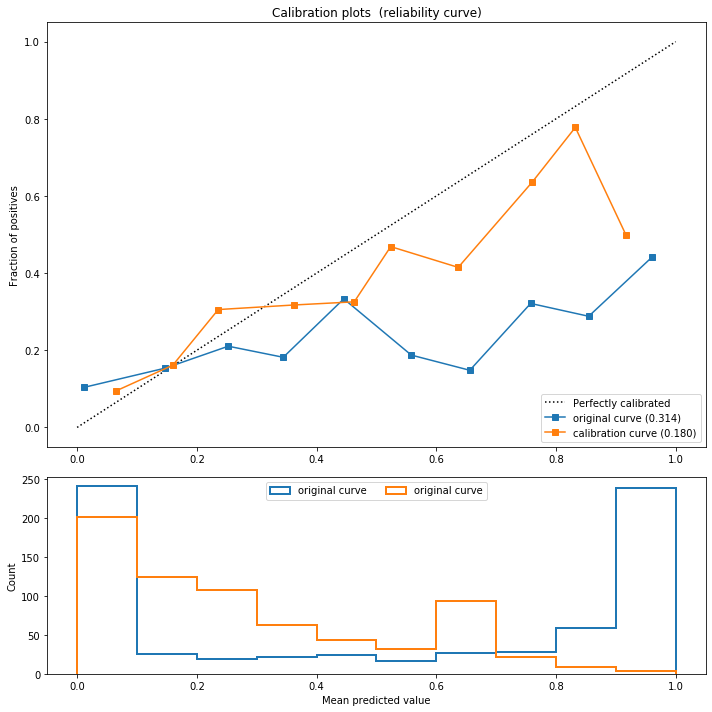

In [10]:
plot_calibration_curve(y_test, y_proba, y_proba_isotonic)

### 2. 绘制不同分类器的校准曲线，分别使用isotonic和sigmoid的方法，输出brier分数
传入参数说明

est：分类器（model）

name: 分类器名称（str）

In [11]:
def plot_calibration_curve(est, name):
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline, 可自行修改
    lr = LogisticRegression(C=1.)

    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

### 示例数据准备

In [12]:
from sklearn import datasets

X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)

### 绘制校准曲线

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

Naive Bayes:
	Brier: 0.118
	Precision: 0.857
	Recall: 0.876
	F1: 0.867

Naive Bayes + Isotonic:
	Brier: 0.098
	Precision: 0.883
	Recall: 0.836
	F1: 0.859

Naive Bayes + Sigmoid:
	Brier: 0.109
	Precision: 0.861
	Recall: 0.871
	F1: 0.866



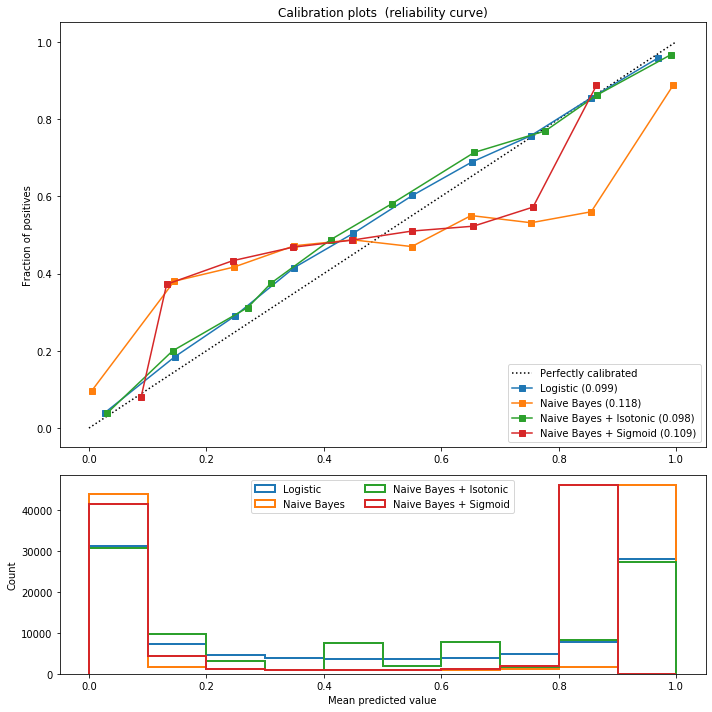

In [13]:
from sklearn.naive_bayes import GaussianNB

# 传入分类器及分类器名称
plot_calibration_curve(GaussianNB(), "Naive Bayes")
plt.show()

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

SVC:
	Brier: 0.163
	Precision: 0.872
	Recall: 0.852
	F1: 0.862

SVC + Isotonic:
	Brier: 0.100
	Precision: 0.853
	Recall: 0.878
	F1: 0.865

SVC + Sigmoid:
	Brier: 0.099
	Precision: 0.874
	Recall: 0.849
	F1: 0.861



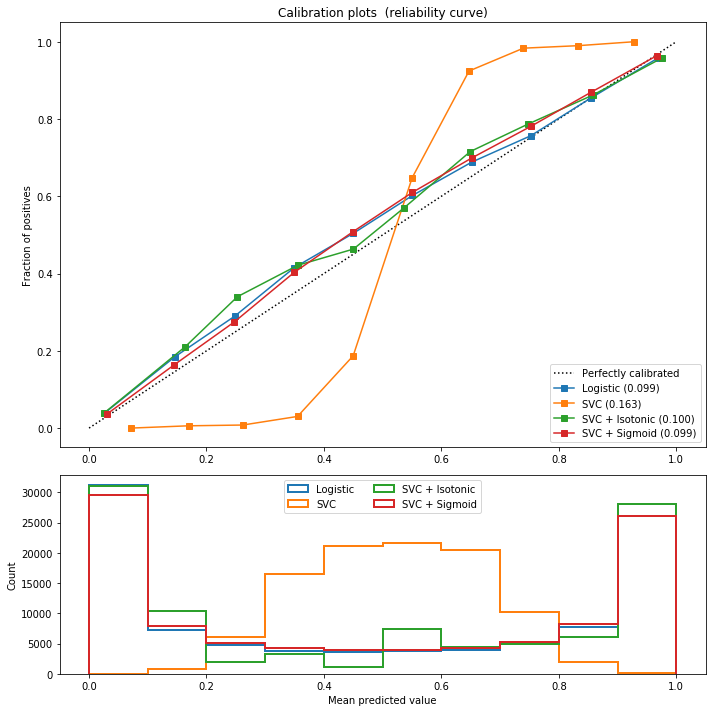

In [14]:
from sklearn.svm import LinearSVC

plot_calibration_curve(LinearSVC(max_iter=10000), "SVC")
plt.show()

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

RandomForest:
	Brier: 0.100
	Precision: 0.872
	Recall: 0.843
	F1: 0.858

RandomForest + Isotonic:
	Brier: 0.097
	Precision: 0.876
	Recall: 0.843
	F1: 0.860

RandomForest + Sigmoid:
	Brier: 0.098
	Precision: 0.876
	Recall: 0.850
	F1: 0.863



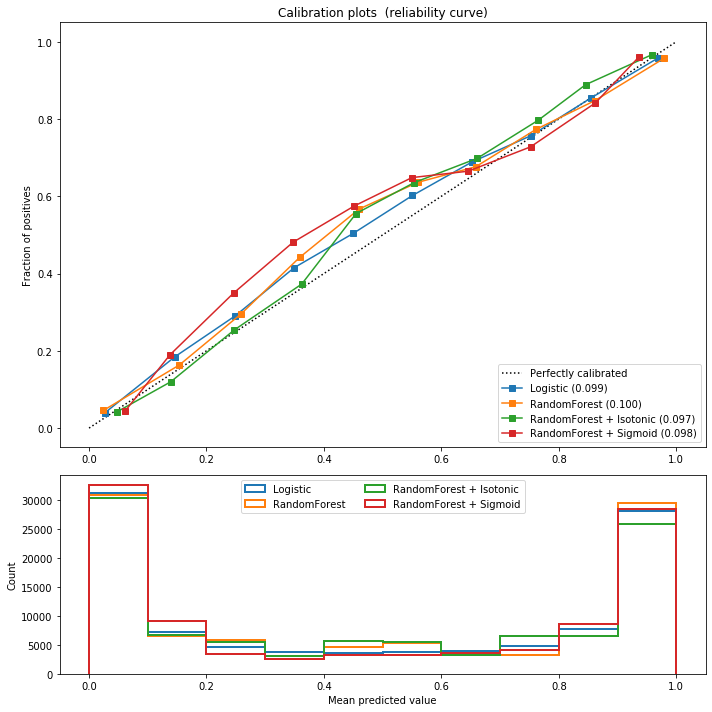

In [15]:
from sklearn.ensemble import RandomForestClassifier

plot_calibration_curve(RandomForestClassifier(n_estimators=25), "RandomForest")
plt.show()